In [498]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import time
from sklearn import metrics
from sklearn.tree import export_text
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, validation_curve, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')
print(time.time())

1664151113.7916758


In [499]:
results=[['Precision', 'Recall', 'Accuracy', 'Balanced Accuracy','Time']]

In [508]:
df = pd.read_csv('/Users/qingzhou/Desktop/GT_OMSCS/Machine_Learning_CS7641/assignment_1/winequality-white.csv')
df.isnull().sum()
x_features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
y_output = ['quality']
class_name = ['bad', 'good']
target_idx = df[df.quality >=6].index
sample_idx = df[df.quality <6].index
# print(target_idx.shape, sample_idx.shape)
# sample_size = sum(df_y.quality == 0)
# print(sample_size)
# random_idx = np.random.choice(target_idx, sample_size, replace=False)
# data_idx= np.concatenate((random_idx, sample_idx))
# print(data_idx.shape)
# print(type(random_idx))
# data = df.loc[data_idx]
# data.head()
data = df

Text(0.5, 1.0, 'Wine Data Heatmap')

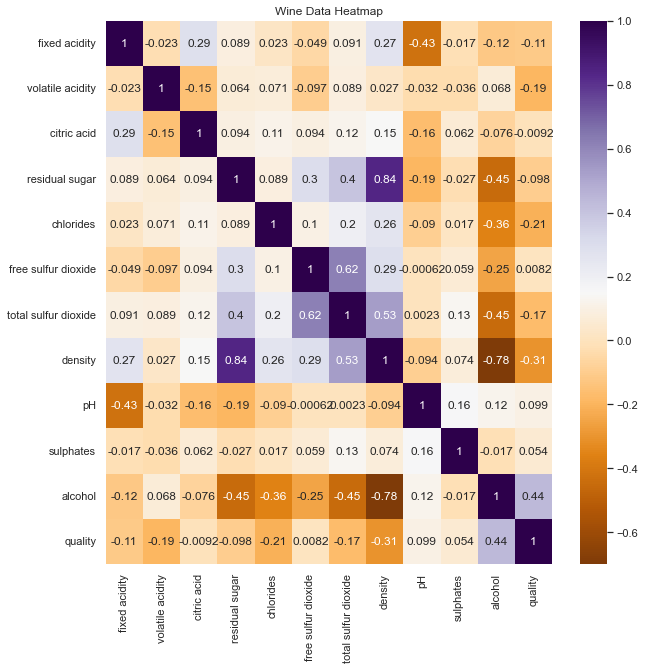

In [509]:
sns.set(rc={'figure.figsize':(10,10)})
ax = plt.axes()
sns.heatmap(data.corr(), annot=True, ax =ax, linecolor="white",vmin=-0.7, cmap="PuOr")
ax.set_title('Wine Data Heatmap')

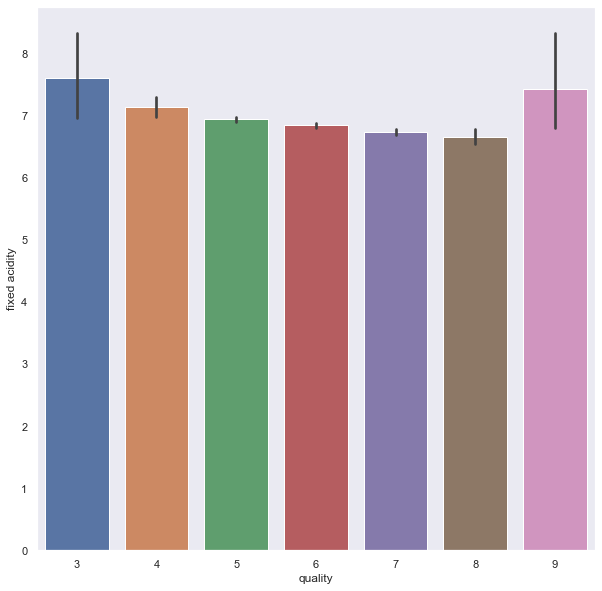

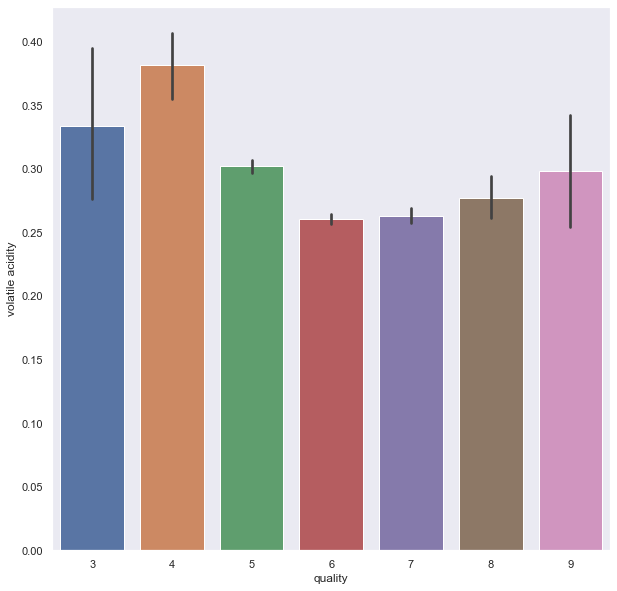

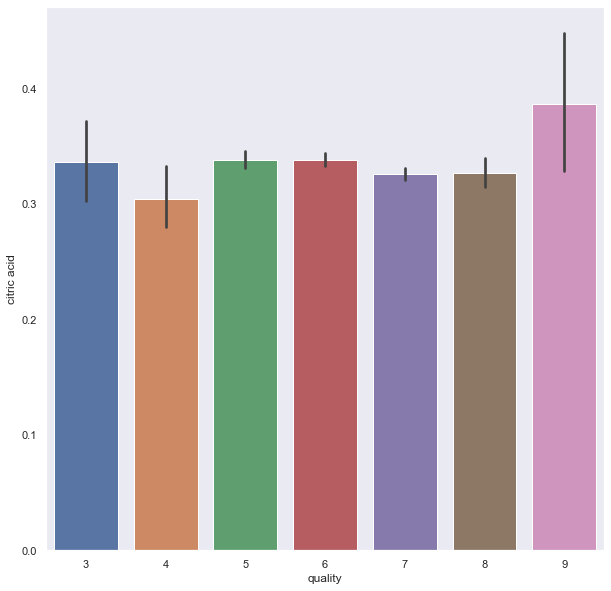

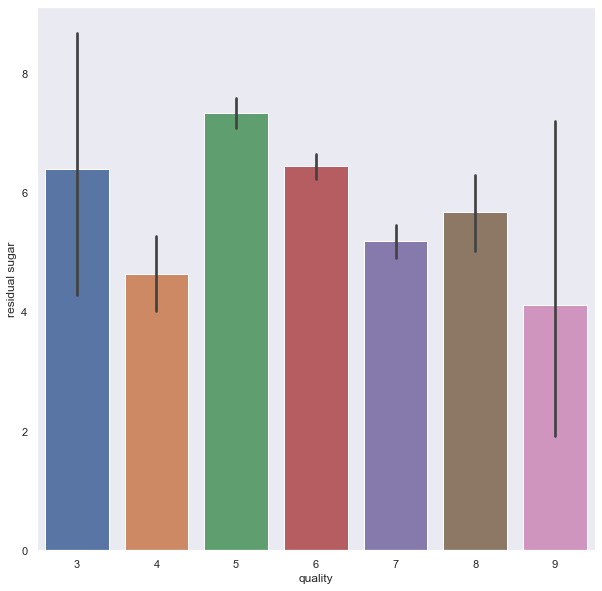

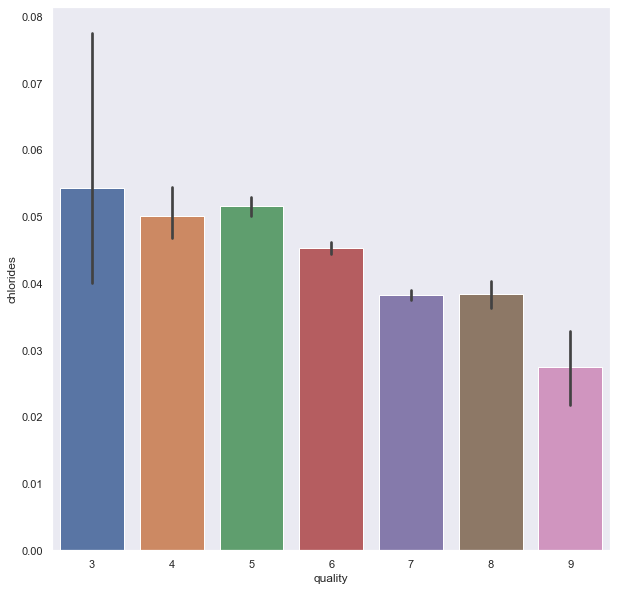

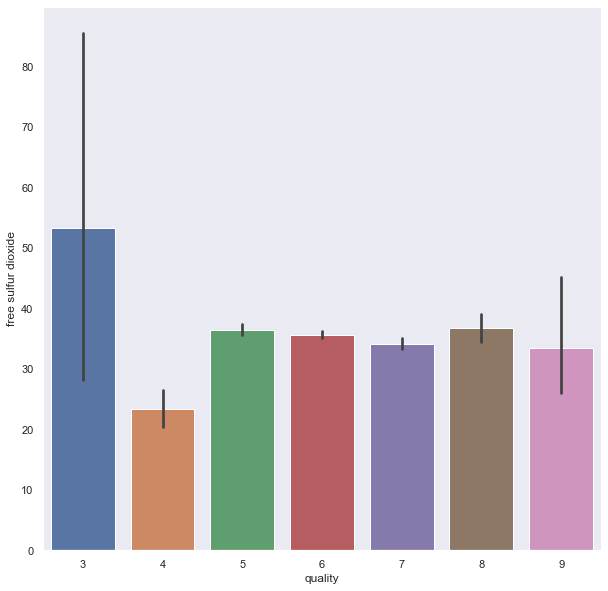

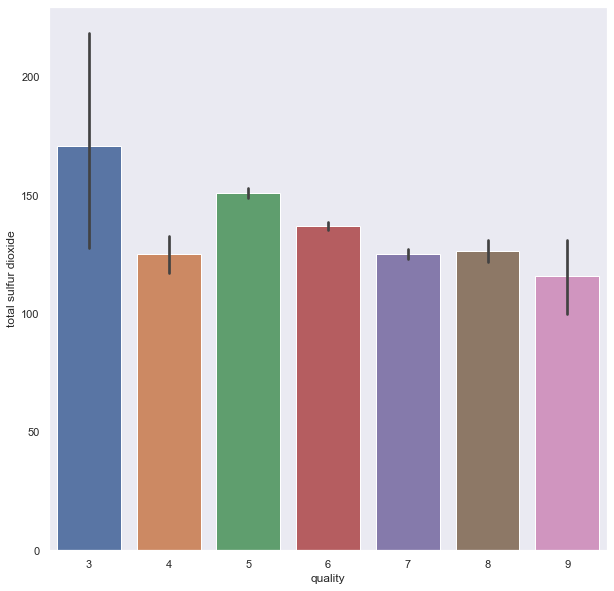

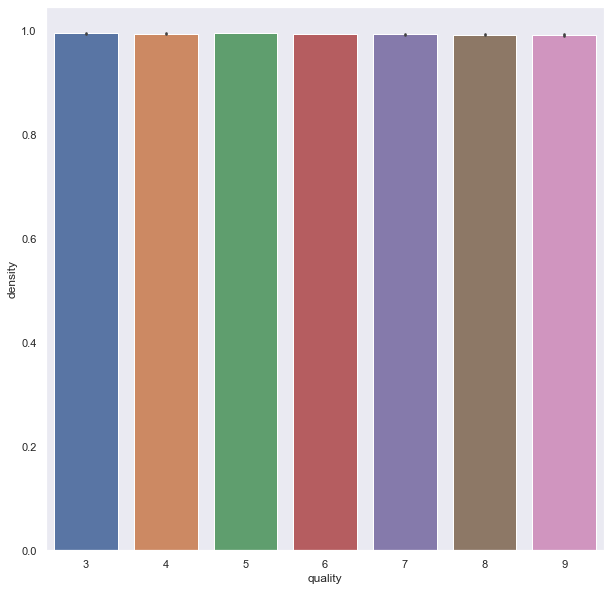

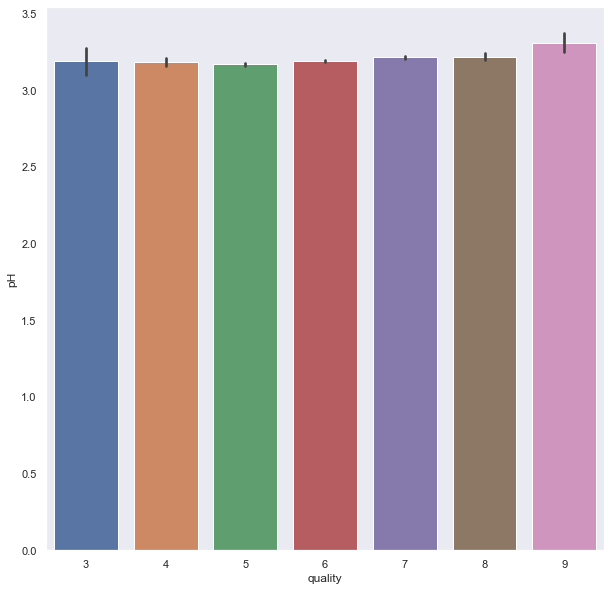

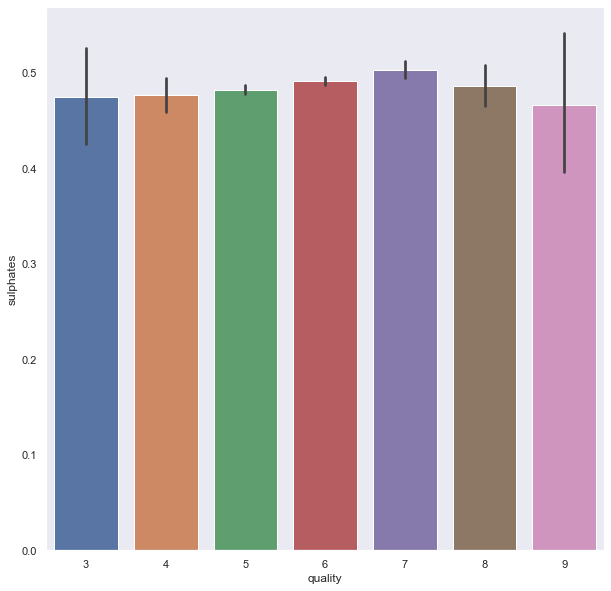

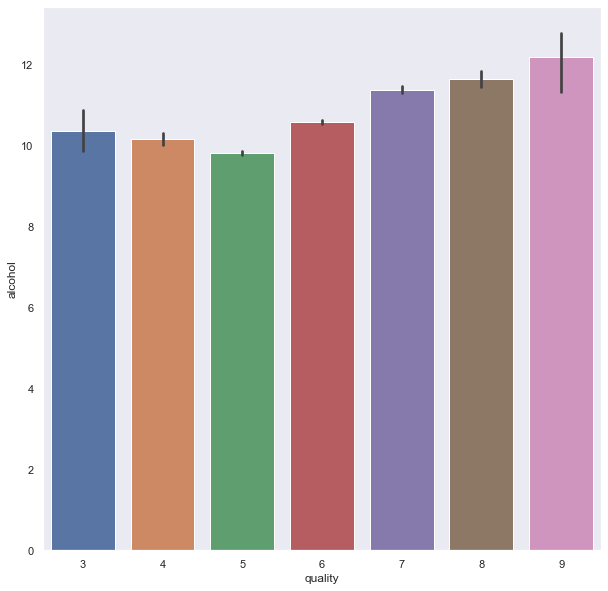

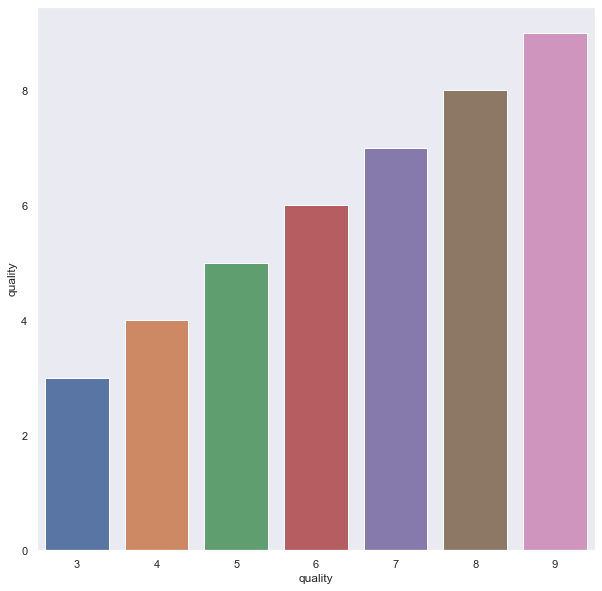

In [511]:
for i, col in enumerate(data.columns):
    plt.figure(i)
    plt.grid(False)
    sns.barplot(x='quality', y=col, data=data)

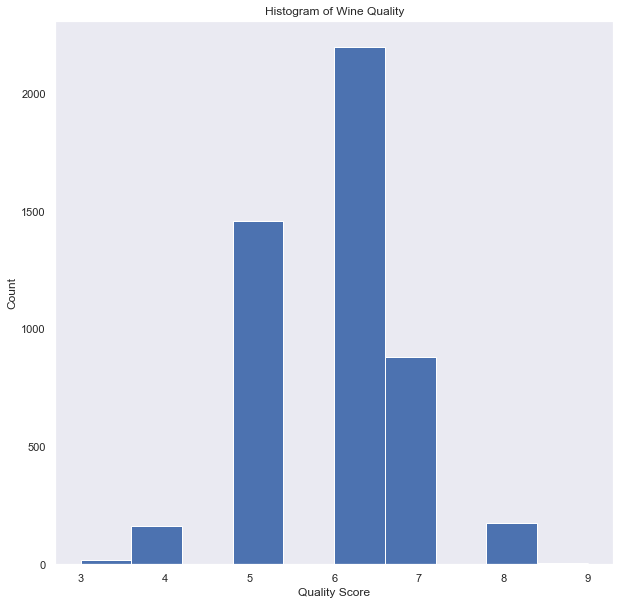

In [513]:
df_x, df_y = data[x_features], data[y_output]
plt.hist(df_y)
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.title('Histogram of Wine Quality')
plt.grid(False)
df_y['quality'].mask(df['quality'] <=5, 0, inplace= True)
df_y['quality'].mask(df['quality'] >=6, 1, inplace= True)
sc = StandardScaler()
X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, test_size=0.2)
X_train, X_test = sc.fit_transform(X_train), sc.fit_transform(X_test)

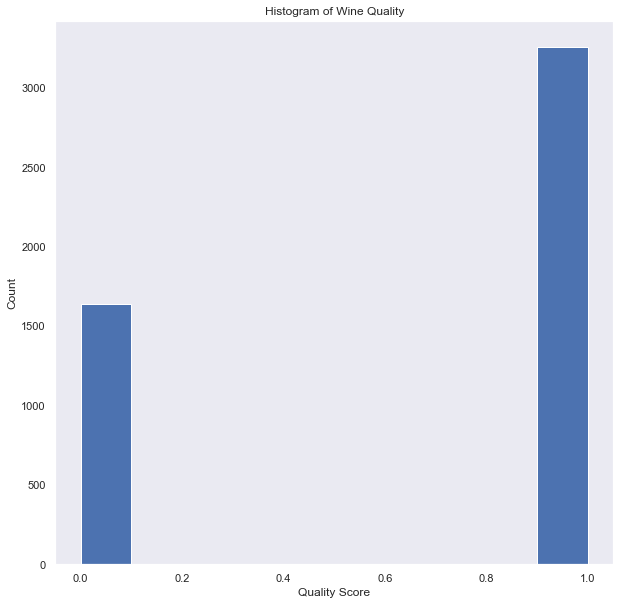

In [514]:
plt.hist(df_y)
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.title('Histogram of Wine Quality')
plt.grid(False)
plt.show()


In [515]:
def prediction(pred, y):
    return metrics.precision_score(y, pred), metrics.recall_score(y, pred), metrics.accuracy_score(y, pred), metrics.confusion_matrix(y, pred), metrics.balanced_accuracy_score(y, pred)

In [516]:
def valid(model, x, y, param, prange, folds, model_name, xlab):
    train, val = validation_curve(model, x, y, param_name=param, param_range=prange, cv=folds)
    train_mean = np.mean(train, axis=1)
    train_std = np.std(train, axis=1)
    val_mean = np.mean(val, axis=1)
    val_std = np.std(val, axis=1)
    
    plt.grid(False)
    plt.title("Validation Curve with "+ model_name)
    plt.xlabel(xlab)
    plt.ylabel("Accuracy")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(
        prange, train_mean, label="Training Accuracy", color="navy", lw=lw
    )
    plt.fill_between(
        prange,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.semilogx(
        prange, val_mean, label="Cross-validation Accuracy", color="darkorange", lw=lw
    )
    plt.fill_between(
        prange,
        val_mean - val_std,
        val_mean + val_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
    plt.legend(loc="best")
    return train, val


In [517]:
def learning(model, x, y, folds, model_name):
    
    size, train, val, fit, _ = learning_curve(model, x, y, cv=folds, return_times=True)
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].set_title('Learning Curve of ' + model_name)
    axes[0].set_xlabel("Training Number")
    axes[0].set_ylabel("Accuracy")
#     print(train)
#     print(val)
    train_mean = np.mean(train, axis=1)
    train_std = np.std(train, axis=1)
    val_mean = np.mean(val, axis=1)
    val_std = np.std(val, axis=1)
    fit_mean = np.mean(fit, axis=1)
    fit_std = np.std(fit, axis=1)
    axes[0].grid()
    axes[0].fill_between(
        size,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.1,
        color="navy",
    )
    axes[0].fill_between(
        size,
        val_mean - val_std,
        val_mean + val_std,
        alpha=0.1,
        color="darkorange",
    )
    axes[0].plot(
        size, train_mean, "o-", color="navy", label="Training Accuracy"
    )
    axes[0].plot(
        size, val_mean, "o-", color="darkorange", label="Cross-validation scAccuracyore"
    )
    axes[0].legend(loc="best")
    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(size, fit_mean, "o-")
    axes[1].fill_between(
        size,
        fit_mean - fit_std,
        fit_mean + fit_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training Number")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the "+ model_name)

    # Plot fit_time vs score
    fit_argsort = fit_mean.argsort()
    fit_sorted = fit_mean[fit_argsort]
    val_mean_sorted = val_mean[fit_argsort]
    val_std_sorted = val_std[fit_argsort]
    axes[2].grid()
    axes[2].plot(fit_sorted, val_mean_sorted, "o-")
    axes[2].fill_between(
        fit_sorted,
        val_mean_sorted - val_std_sorted,
        val_mean_sorted + val_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("Fit Times")
    axes[2].set_ylabel("Accuracy")
    axes[2].set_title("Performance of the "+ model_name)

In [518]:
def dt(x,y, x_test, y_test):
    #set up model
    model = DecisionTreeClassifier(random_state=0)
    #validation curve
    train, val = valid(model, df_x, df_y,'max_depth', [1,1000], 5, 'Decision Tree', 'Depth' )
    #learning curve
    model = DecisionTreeClassifier(random_state=0, max_depth = 110)
#     learning(model, df_x, df_y, 5, 'Decision Tree')
    #purning 
    path = model.cost_complexity_pruning_path(x,y)
    alphas, impurities =  path.ccp_alphas, path.impurities
    
    #plot alpha to impurity
    fig, ax = plt.subplots()
    plt.grid(False)
    ax.plot(alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
    ax.set_xlabel("Effective Alpha")
    ax.set_ylabel("Total Impurity of Leaves")
    ax.set_title("Total Impurity vs Effective Alpha for Training set")
    
    #store model fitting
    models = []
    for a in alphas:
        model = DecisionTreeClassifier(random_state=0, ccp_alpha=a, max_depth =110)
        model.fit(x,y)
        models.append(model)
    #remove one node from alphas and output
    models = models[:-1]
    alphas = alphas[:-1]
    node_counts = [model.tree_.node_count for model in models]
    depth = [model.tree_.max_depth for model in models]
    
    #plot alpha to node
    fig, ax = plt.subplots(2,1)
    ax[0].grid(False)
    ax[0].plot(alphas, node_counts, marker="o", drawstyle="steps-post")
    ax[0].set_xlabel("Alpha")
    ax[0].set_ylabel("Number of Nodes")
    ax[0].set_title("Number of Nodes vs Alpha")
    #plot alpha to depth
    plt.grid(False)
    ax[1].plot(alphas, depth, marker="o", drawstyle="steps-post")
    ax[1].set_xlabel("Alpha")
    ax[1].set_ylabel("Depth of Tree")
    ax[1].set_title("Depth vs Alpha")
    fig.tight_layout()
    
    train_scores = [model.score(x, y) for model in models]
    test_scores = [model.score(x_test, y_test) for model in models]
    fig, ax = plt.subplots()
    plt.grid(False)
    ax.set_xlabel("Alpha")
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy vs Alpha for Training and Validation sets")
    ax.plot(alphas, train_scores, marker="o", label="Train", drawstyle="steps-post")
    ax.plot(alphas, test_scores, marker="o", label="Validation", drawstyle="steps-post")
    ax.legend()
    #calculate performance
    pre, rec, acc, m_node, m_dep, i, mtx, bacc = 0, 0 ,0, 0, 0, 0, [], 0
    for model, node, dep in zip(models, node_counts, depth):
        temp4, temp5 = node, dep
        pred = model.predict(x_test)
#         print('Number of Nodes :', node, 'Depth: ', dep)
        temp1, temp2, temp3, temp6, temp7= prediction(pred, y_test)
        if acc < temp3:
            i = models.index(model)
            pre, rec, acc, m_node, m_dep, mtx, bacc= temp1, temp2, temp3, temp4, temp5, temp6, temp7
    print('Number of Nodes :', m_node, 'Depth: ', m_dep)
    print('Precision: ',  pre)
    print('Recall: ',  rec)
    print('Accuracy: ',  acc)
    print('Balanced Accuracy: ', bacc)
    print(mtx)
    print(i)
    start = time.time()
    learning(models[i], df_x, df_y, 5, 'Decision Tree')
    models[i].fit(x,y)
    wall_time = time.time() - start
    results.append([pre, rec, acc, bacc, wall_time])

    return models, i

Number of Nodes : 341 Depth:  17
Precision:  0.8225308641975309
Recall:  0.8187403993855606
Accuracy:  0.7622448979591837
Balanced Accuracy:  0.7345981632186163
[[214 115]
 [118 533]]
211


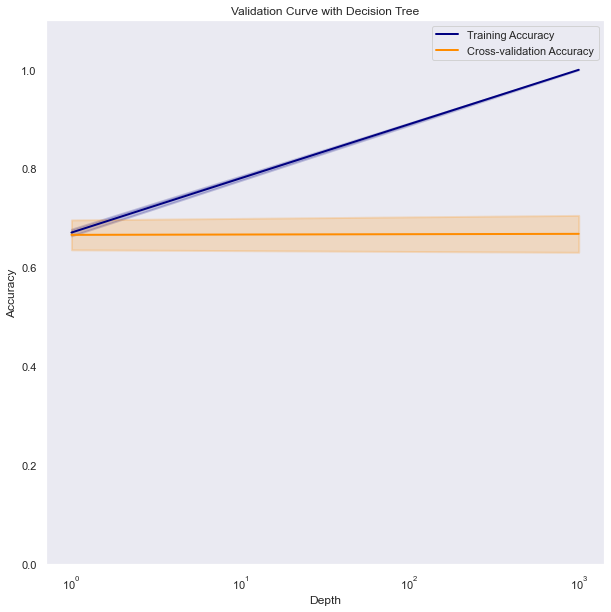

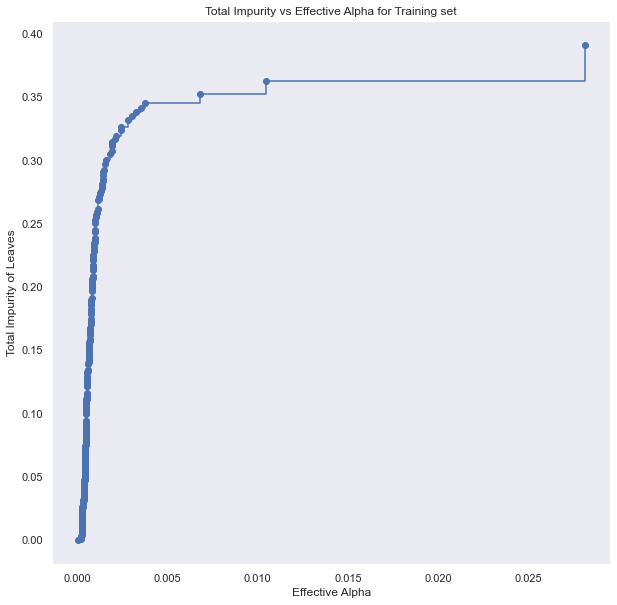

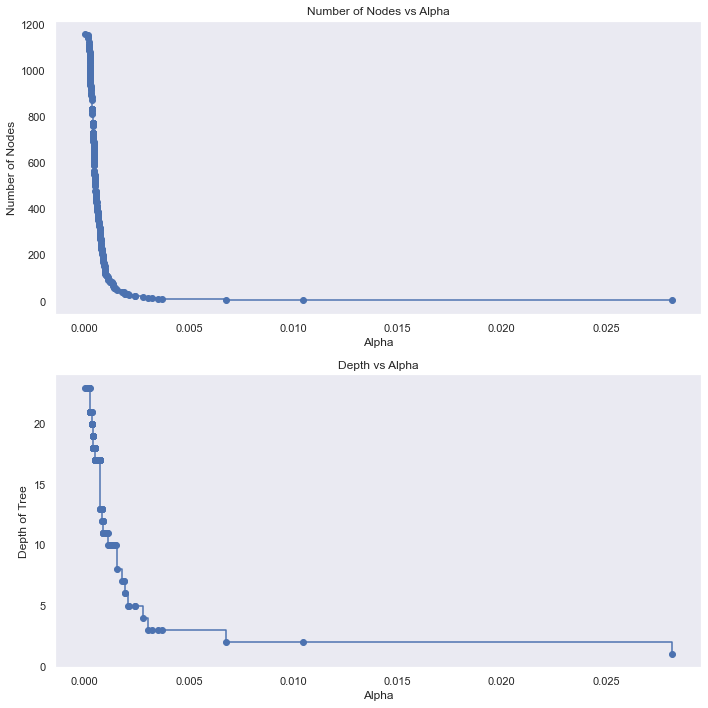

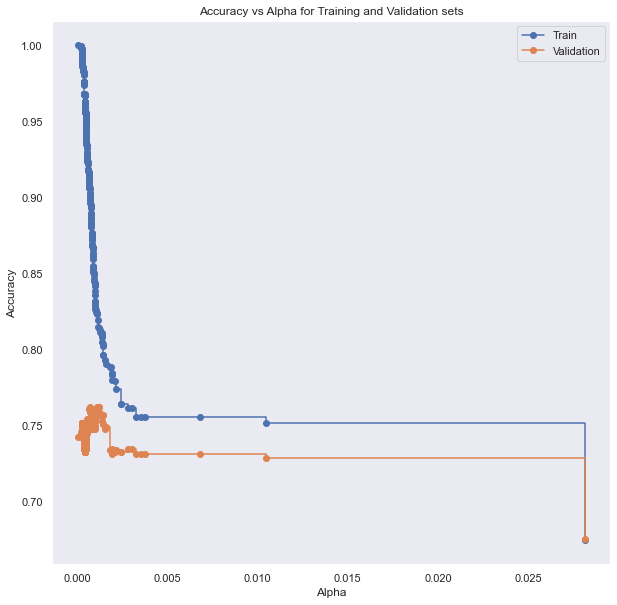

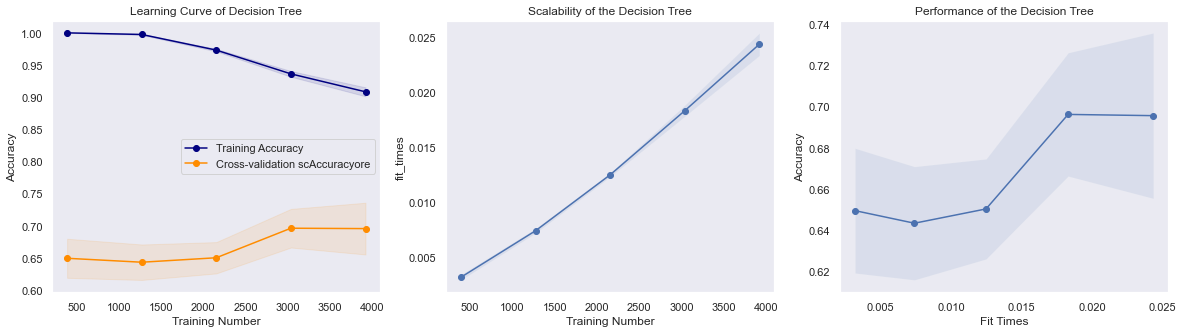

In [519]:
dt_output, idx = dt(X_train, Y_train, X_test, Y_test)

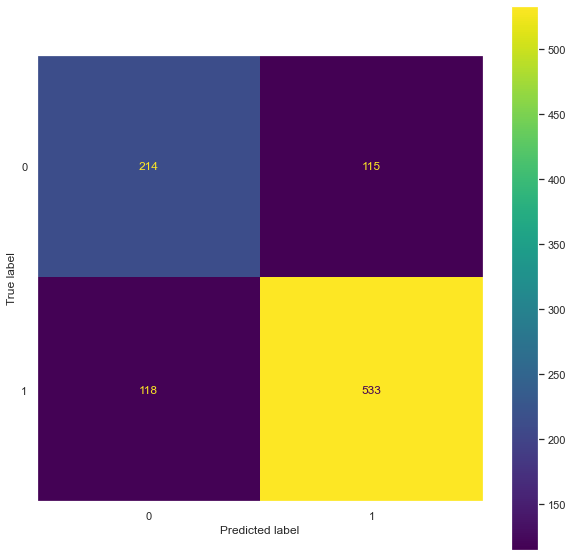

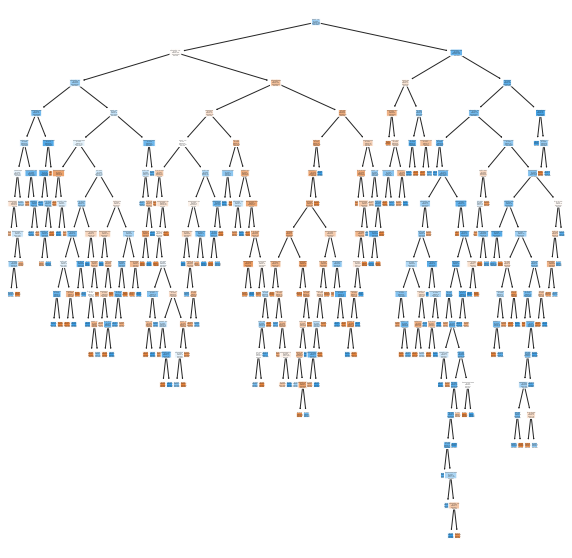

In [520]:

model = dt_output[idx]

metrics.plot_confusion_matrix(model, X_test, Y_test)
plt.grid(False)

# fig = plt.figure(figsize=(20, 25))
fig = plt.figure()
_ = tree.plot_tree(model, feature_names = x_features, class_names = class_name, filled = True, rounded = True)
# fig.savefig('test.png', dpi = 1200)

In [521]:
def nn(x,y, x_test, y_test):
    model = MLPClassifier(random_state=0, activation='identity', hidden_layer_sizes=(25,2))
    
    
#     #validation curve
#     train, val = valid(model, df_x, df_y,'learning_rate_init', [1e-5,1], 5, 'Neural Network', 'Learning Rate' )
    train, val = valid(model, df_x, df_y,'n_iter_no_change', [1, 1000], 5, 'Neural Network', 'Epochs Number' )
#     train, val = valid(model, df_x, df_y,'hidden_layer_sizes', [1,1000], 5, 'Neural Network', 'Hidden Layer')

    model = MLPClassifier(n_iter_no_change=7, learning_rate_init=1e-3, hidden_layer_sizes=(25,2), random_state=0, activation='identity', alpha = 1e-3)
    #learning curve
#     model.
    learning(model, df_x, df_y, 5, 'Neural Network')
    model.fit(x_test,y_test)
    loss_val = model.loss_curve_
    start = time.time()
    model.fit(x,y)
    wall_time = time.time() - start
    loss_train = model.loss_curve_
    pred = model.predict(x_test)
    pre, rec, acc, mtx, bacc = prediction(pred, y_test)
    print('Precision: ',  pre)
    print('Recall: ',  rec)
    print('Accuracy: ',  acc)
    print('Balanced Accuracy: ', bacc)
    print(mtx)
    results.append([pre, rec, acc, bacc, wall_time])
    metrics.plot_confusion_matrix(model, x_test, y_test)
    plt.grid(False)
    return [loss_train, loss_val]

Precision:  0.7836338418862691
Recall:  0.8678955453149002
Accuracy:  0.753061224489796
Balanced Accuracy:  0.6968657057881492
[[173 156]
 [ 86 565]]


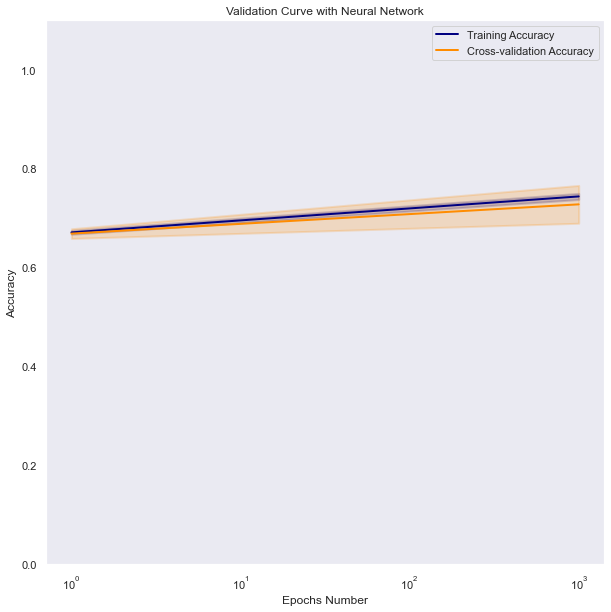

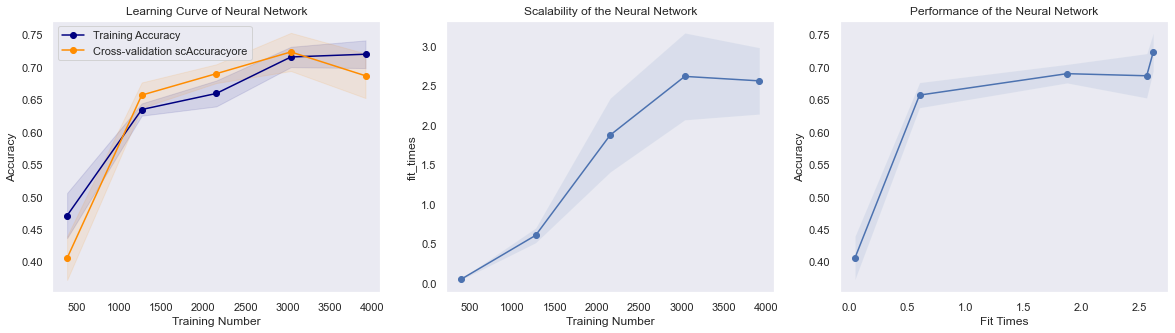

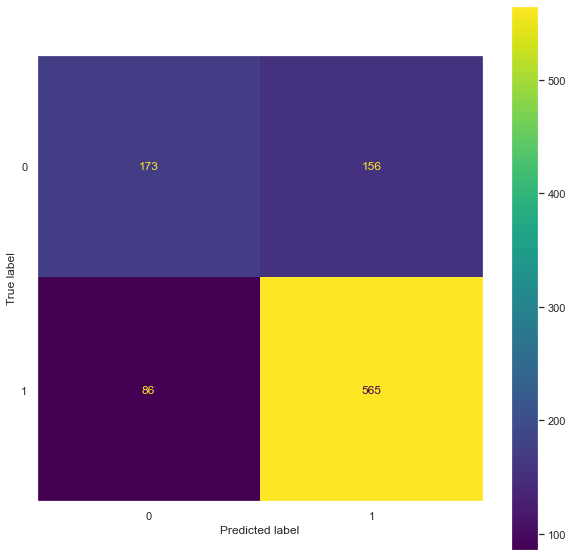

In [522]:
nn_output = nn(X_train, Y_train, X_test, Y_test)

Text(0.5, 1.0, 'Loss function of Neural Network')

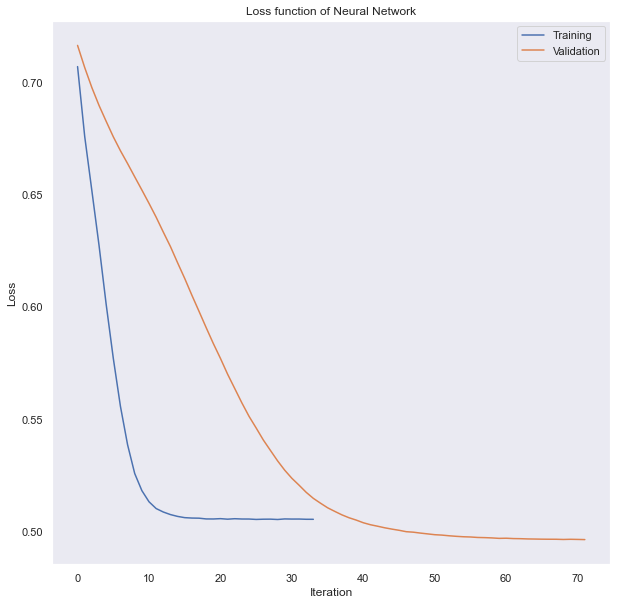

In [523]:
plt.plot(nn_output[0], label="Training")
plt.plot(nn_output[1], label="Validation")
plt.grid(False)
plt.legend(loc="upper right")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss function of Neural Network")


In [524]:
def boosting(x,y, x_test, y_test):
    model = AdaBoostClassifier(random_state=0)
#     train, val = valid(model, df_x, df_y,'learning_rate', [1e-5, 1], 5, 'Adaboost', 'Learning Rate')
    train, val = valid(model, df_x, df_y,'n_estimators', [1, 100], 5, 'Adaboost', 'Number or Estimators')
    model = AdaBoostClassifier(n_estimators=50, random_state=0, learning_rate = 0.0001)
    learning(model, df_x, df_y, 5, 'Adaboost')
    start = time.time()
    model.fit(x,y)
    wall_time = time.time() - start
    pred = model.predict(x_test)
    pre, rec, acc, mtx, bacc = prediction(pred, y_test)
    print('Precision: ',  pre)
    print('Recall: ',  rec)
    print('Accuracy: ',  acc)
    print('Balanced Accuracy: ', bacc)
    print(mtx)
    metrics.plot_confusion_matrix(model, x_test, y_test)
    results.append([pre, rec, acc, bacc, wall_time])
    plt.grid(False)


Precision:  0.8258317025440313
Recall:  0.6482334869431644
Accuracy:  0.6755102040816326
Balanced Accuracy:  0.6888583848089682
[[240  89]
 [229 422]]


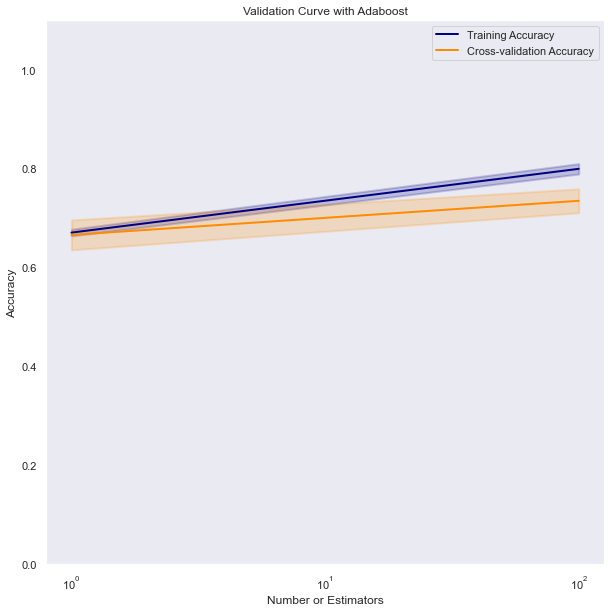

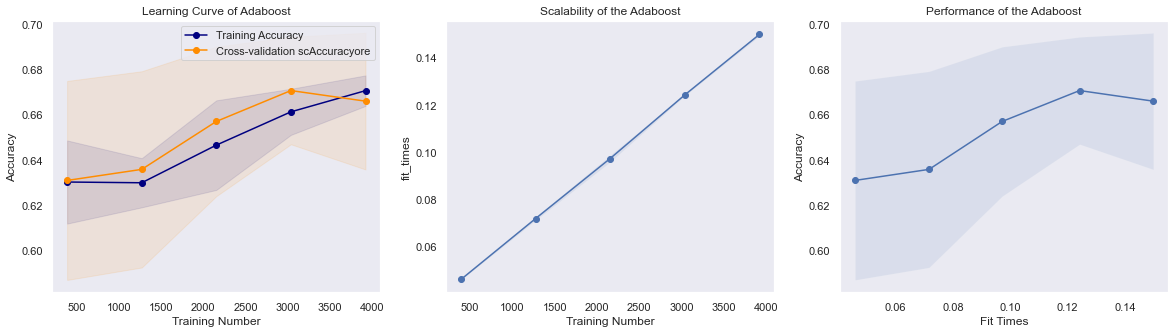

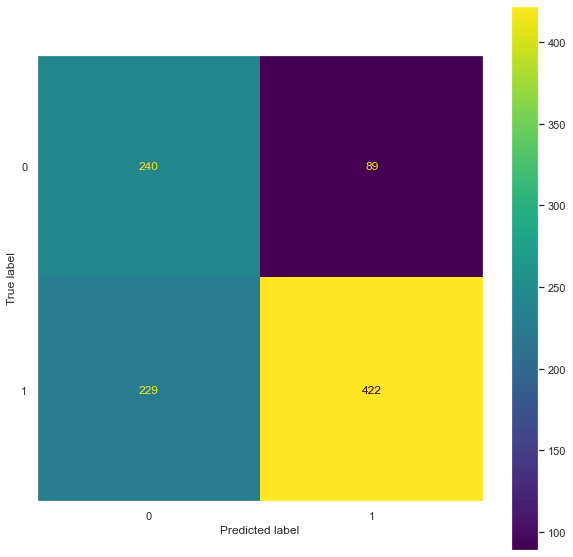

In [525]:
boosting(X_train, Y_train, X_test, Y_test)

In [526]:
#two type of kernel function
def svm(x,y, x_test, y_test, kernelf):
    model = SVC(kernel = kernelf, random_state=0)
#     train, val = valid(model, df_x, df_y,'gamma', np.logspace(-6, -1, 5), 5, 'SVM', r"$\gamma$")
    train, val = valid(model, df_x, df_y,'C', [0.2,1.0], 5, 'SVM', 'C')
    model = SVC(kernel = kernelf, C=0.4, gamma=5.62341325e-03)
    learning(model, df_x, df_y, 5, 'SVM')
    start = time.time()
    model.fit(x,y)
    wall_time = time.time() - start
    pred = model.predict(x_test)
    pre, rec, acc, mtx, bacc = prediction(pred, y_test)
    print('Precision: ',  pre)
    print('Recall: ',  rec)
    print('Accuracy: ',  acc)
    print('Balanced Accuracy: ', bacc)
    print(mtx)
    metrics.plot_confusion_matrix(model, x_test, y_test)
    results.append([pre, rec, acc, bacc, wall_time])
    plt.grid(False)

Precision:  0.7788461538461539
Recall:  0.8709677419354839
Accuracy:  0.75
Balanced Accuracy:  0.6908030199039121
[[168 161]
 [ 84 567]]


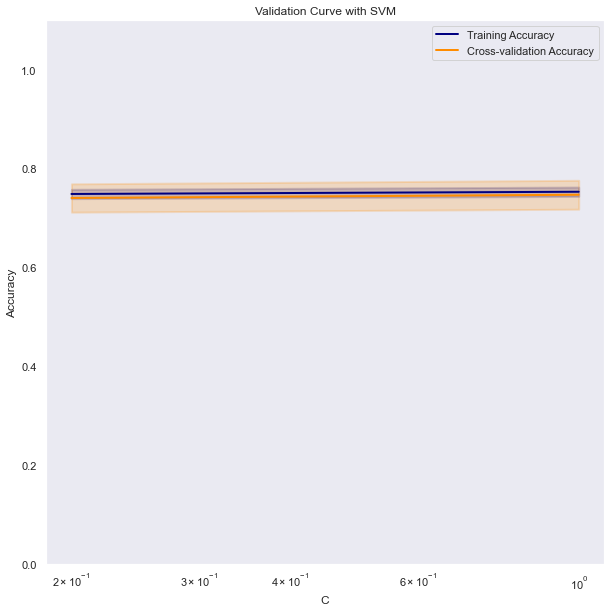

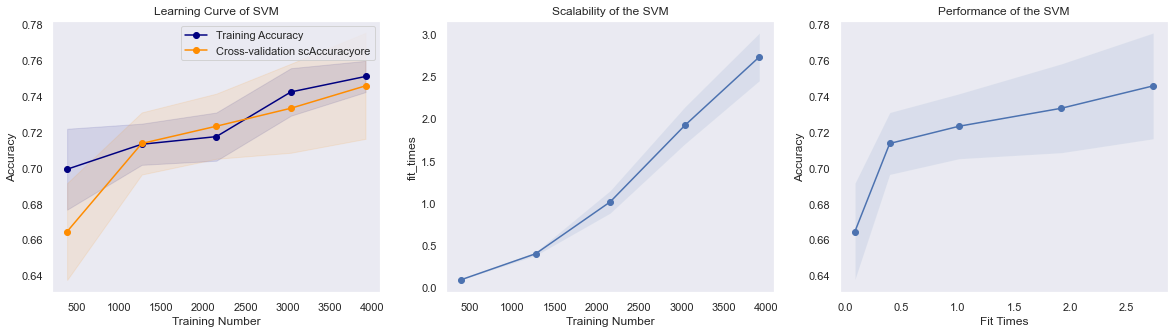

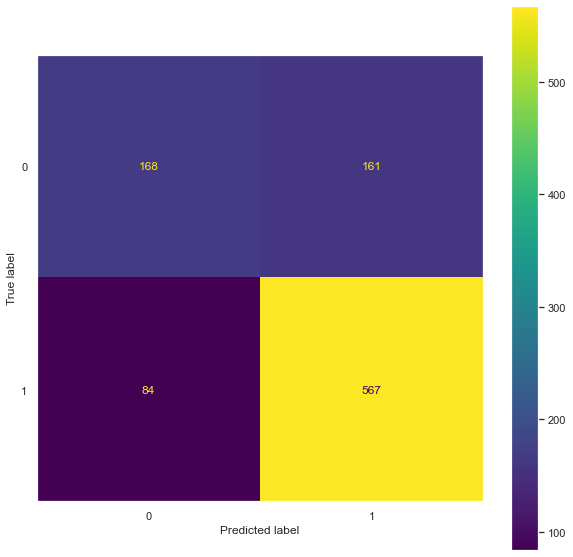

In [527]:
svm(X_train, Y_train, X_test, Y_test, 'linear')

In [528]:
# svm(X_train, Y_train, X_test, Y_test, 'sigmoid')

Precision:  0.6649642492339122
Recall:  1.0
Accuracy:  0.6653061224489796
Balanced Accuracy:  0.5015197568389058
[[  1 328]
 [  0 651]]


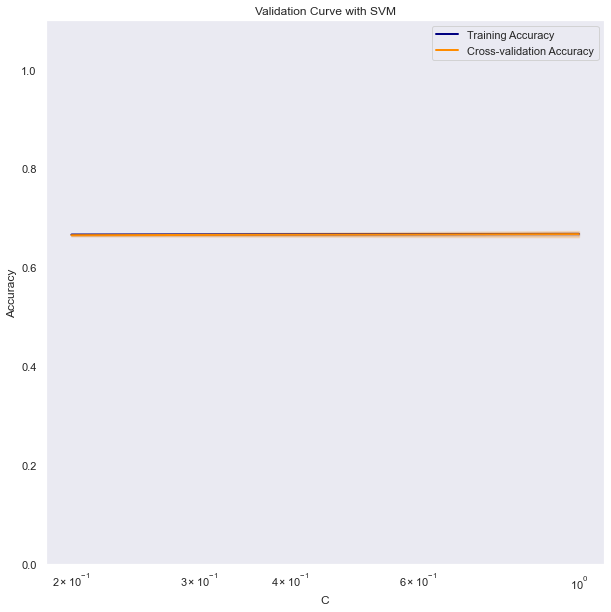

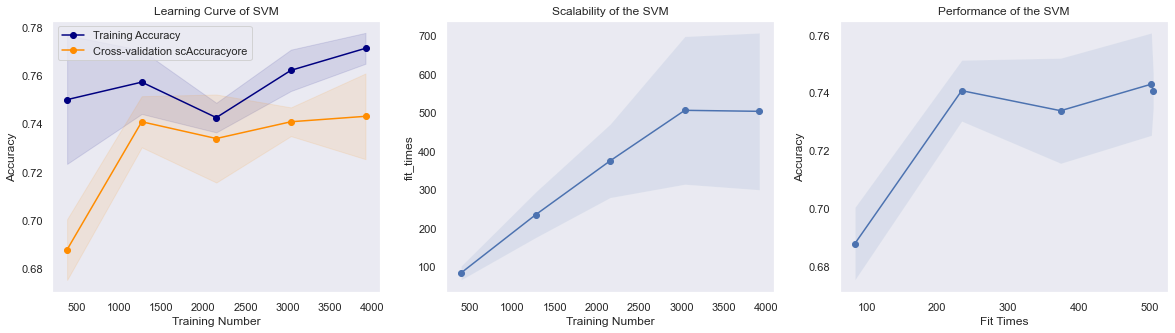

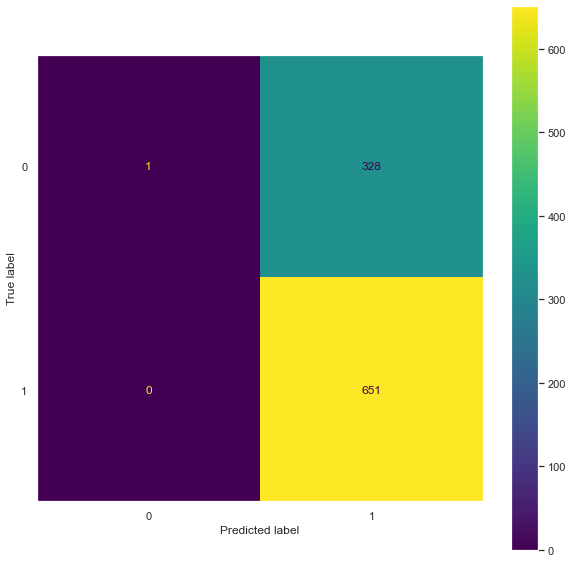

In [529]:
svm(X_train, Y_train, X_test, Y_test, 'poly')

In [530]:
#varying k
def knn(x,y, x_test, y_test, n):
    model = KNeighborsClassifier()
    train, val = valid(model, df_x, df_y,'n_neighbors', [1,1000], 5, 'KNN', 'Number or Neighbors')
    model = KNeighborsClassifier(n_neighbors=50)
    learning(model, df_x, df_y, 5, 'KNN')
    start = time.time()
    model.fit(x,y)
    wall_time = time.time() - start
    pred = model.predict(x_test)
    pre, rec, acc, mtx, bacc = prediction(pred, y_test)
    print('Precision: ',  pre)
    print('Recall: ',  rec)
    print('Accuracy: ',  acc)
    print('Balanced Accuracy: ', bacc)
    print(mtx)
    metrics.plot_confusion_matrix(model, x_test, y_test)
    results.append([pre, rec, acc, bacc, wall_time])
    plt.grid(False)


Precision:  0.8016877637130801
Recall:  0.8755760368663594
Accuracy:  0.773469387755102
Balanced Accuracy:  0.7235023041474654
[[188 141]
 [ 81 570]]


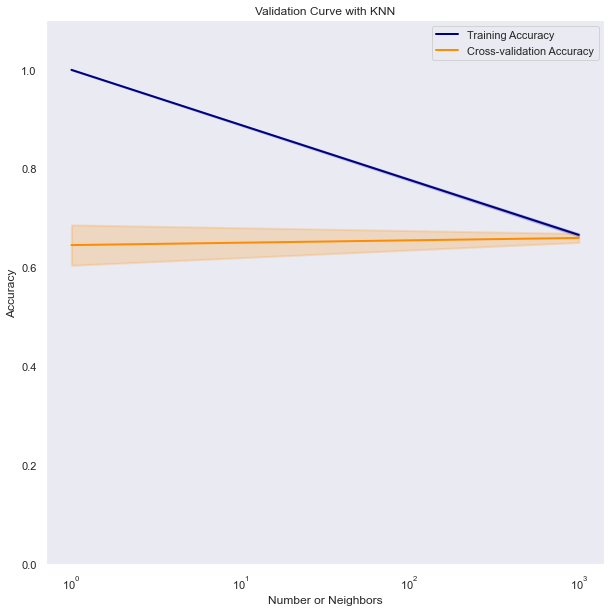

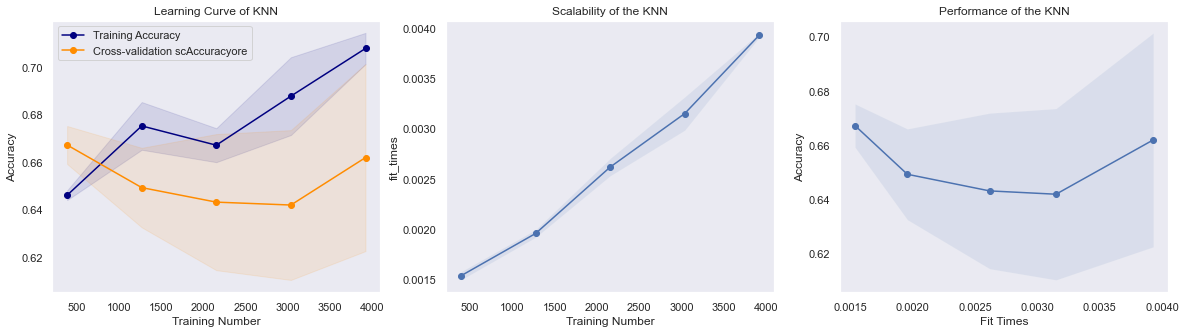

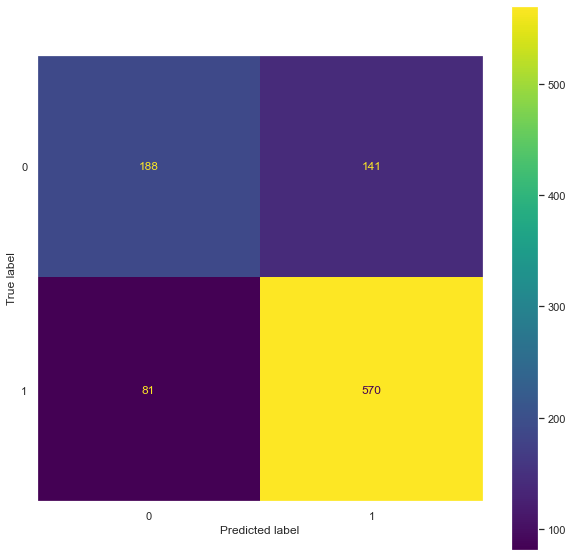

In [531]:
knn_output = knn(X_train, Y_train, X_test, Y_test, 50)

Precision:  0.8016877637130801
Recall:  0.8755760368663594
Accuracy:  0.773469387755102
Balanced Accuracy:  0.7235023041474654
[[188 141]
 [ 81 570]]


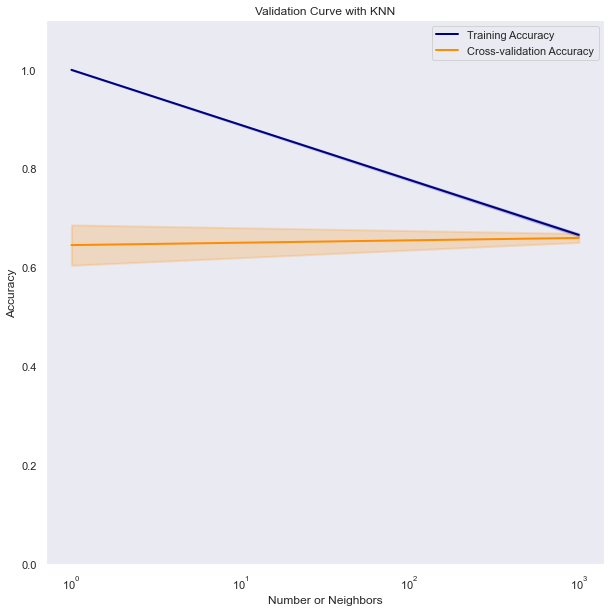

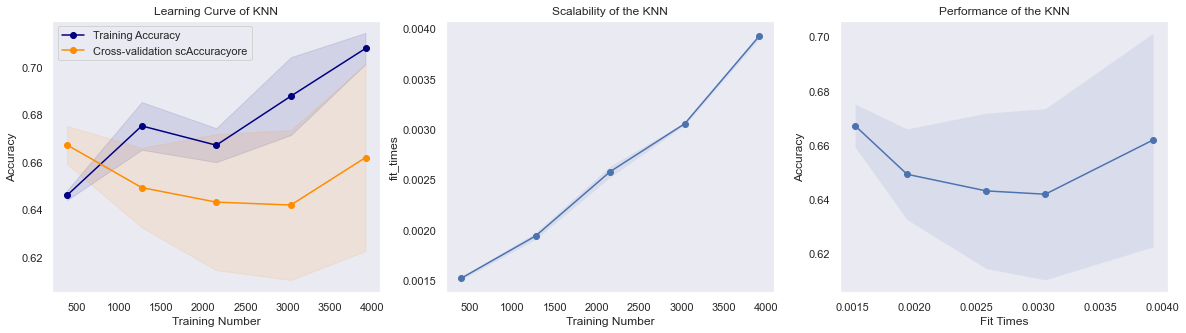

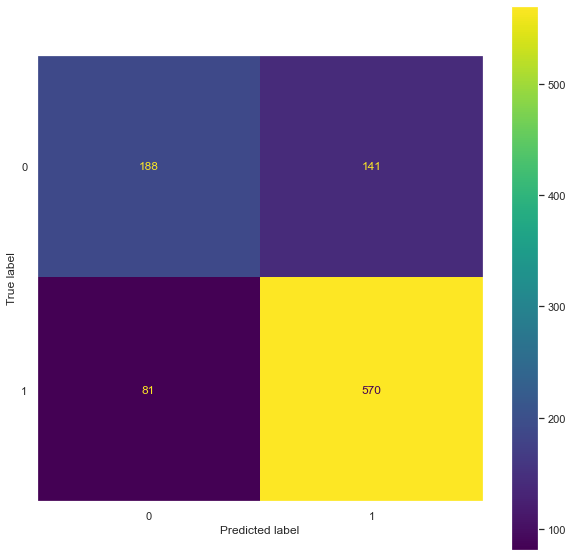

In [532]:
knn_output = knn(X_train, Y_train, X_test, Y_test, 100)

Precision:  0.8016877637130801
Recall:  0.8755760368663594
Accuracy:  0.773469387755102
Balanced Accuracy:  0.7235023041474654
[[188 141]
 [ 81 570]]


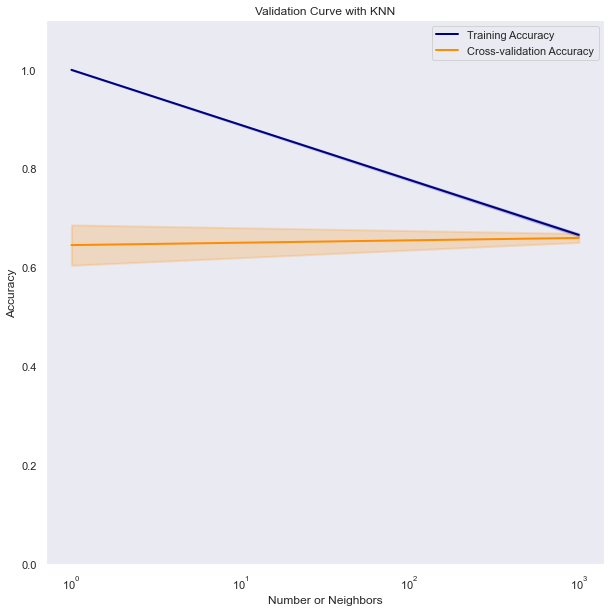

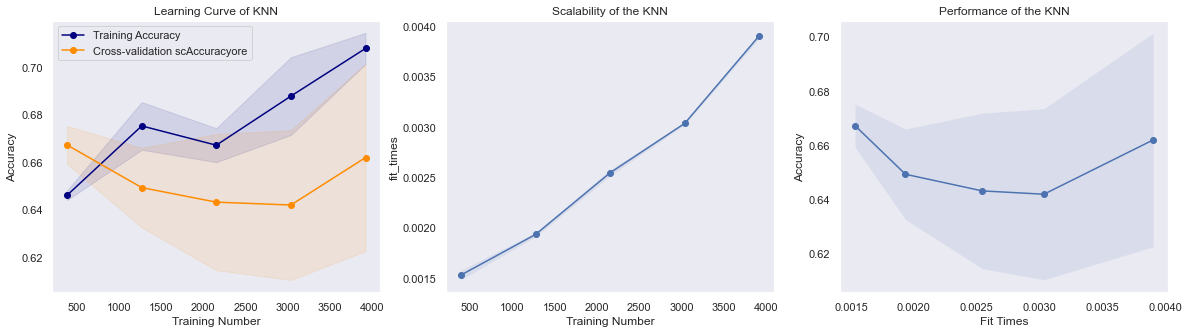

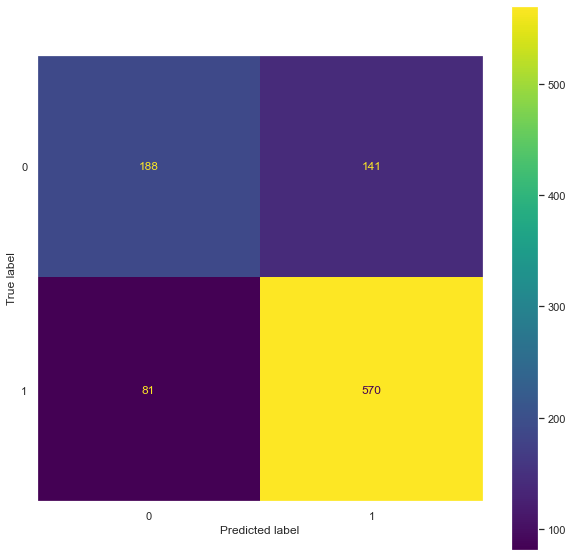

In [533]:
knn_output = knn(X_train, Y_train, X_test, Y_test, 150)

In [534]:
result_df = pd.DataFrame(results)
result_df

,0,1,2,3,4
0,Precision,Recall,Accuracy,Balanced Accuracy,Time
1,0.822531,0.81874,0.762245,0.734598,0.4294
2,0.783634,0.867896,0.753061,0.696866,0.666995
3,0.825832,0.648233,0.67551,0.688858,0.15013
4,0.778846,0.870968,0.75,0.690803,0.443131
5,0.664964,1.0,0.665306,0.50152,0.500988
6,0.801688,0.875576,0.773469,0.723502,0.003262
7,0.801688,0.875576,0.773469,0.723502,0.003204
8,0.801688,0.875576,0.773469,0.723502,0.003209


In [497]:
df_red = pd.read_csv('/Users/qingzhou/Desktop/GT_OMSCS/Machine_Learning_CS7641/assignment_1/winequality-red.csv')
df_red['quality'].mask(df_red['quality'] <=5, 0, inplace= True)
df_red['quality'].mask(df_red['quality'] >=6, 1, inplace= True)

df_red_x = df_red[x_features]
df_red_y = df_red[y_output]



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,1
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,1
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,1
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,0


In [537]:
pred = dt_output[idx].predict(df_red_x.to_numpy())
print(prediction(pred, df_red_y.to_numpy()))

(0.5347091932457786, 1.0, 0.5347091932457786, array([[  0, 744],
       [  0, 855]]), 0.5)
